In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from pims import ImageSequence
from pims import pipeline

import os
from openpiv import tools, pyprocess, validation, filters, scaling

import tracking_tools as track_tools
import piv_fns as piv_tools

In [2]:
## See link below for many details about font sizes on a matplotlib figure 
# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot

## Figure aesthetics
# plt.rcParams.update(plt.rcParamsDefault) # resets to default values
# plt.rcParams.update({'figure.facecolor': 'none'}) # sets figure backgroud to transparent 

fs=14; fst=11 # default size value = 10
# plt.rcParams.update({'font.size': 10}) # all fonts, default
plt.rcParams.update({'axes.labelsize': fs})    # fontsize of the axes labels
plt.rcParams.update({'xtick.labelsize': fst})    # fontsize of the xtick labels
plt.rcParams.update({'ytick.labelsize': fst})    # fontsize of the ytick labels
# plt.rcParams.update({'text.color': 'r'})    # 
plt.rcParams.update({'font.size': fst})    # 

# plt.rcParams.keys() # displays all dictionary keys and values in rcParams

# Read-in frames

In [3]:
## Experiment values 
marble_diam = 3.6 # cm 
framerate = 1000.11 # Hz ; 1/sec

In [ ]:
## Import frames into PIMS imagesequence object 
path = '/vid01_tiffs/*.tiff' 
frames = ImageSequence(path) 
print(frames) 

output_dir = 'piv_output/vid01_xy_single/' 
fname_end = '_vid01_xy_single' 

In [5]:
## Make directory to store frames
if not os.path.exists(output_dir): # if not exits
    os.makedirs(output_dir) # make directory

## Make directory to store frames
if not os.path.exists(output_dir+'piv_vfield_data/'): # if not exits
    os.makedirs(output_dir+'piv_vfield_data/') # make directory

## Make directory to store frames
if not os.path.exists(output_dir+'piv_vmag_hists/'): # if not exits
    os.makedirs(output_dir+'piv_vmag_hists/') # make directory


In [6]:
## Get values for image shape
ny,nx,nc = np.shape(frames[0])
ny,nx,nc

(1080, 1920, 3)

# Display frames
<a id='display_frames'></a>

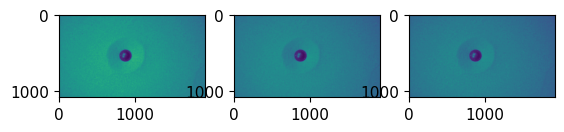

In [7]:
## Display a single frame from both viewpoints
fig,ax = plt.subplots(1,3,dpi=100) 
bb=450
ax[0].imshow(frames[bb][:,:,0]) # red
ax[1].imshow(frames[bb][:,:,1]) # green
ax[2].imshow(frames[bb][:,:,2]) # blue

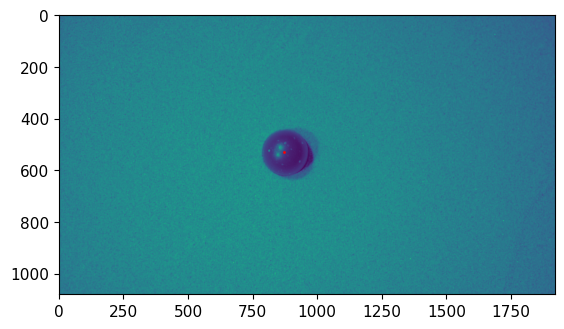

In [8]:
## Get center of impact coordinates
xc = 870; yc = 530
t0_frame = 120 # take video file number and subtract one to account for file naming convention... 

fig,ax = plt.subplots(1,1,dpi=100) 
ax.scatter(xc,yc,c='r',s=1)
ax.imshow(frames[t0_frame][:,:,1]) 
# ax.imshow(frames[t0_frame][:,:,1]-frames[t0_frame+1][:,:,1]) 

pixel scaling: 45.83 px/cm


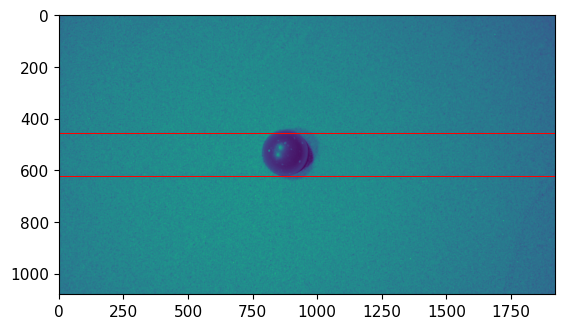

In [9]:
## Pxscale for frames
y1 = 455
y2 = 620
pxscale = track_tools.get_pixel_scale(frames[t0_frame][:,:,1], y1, y2, nx, marble_diam, 'h', 'cm')

In [10]:
## Set extent of image in physical units (for imshow calls) 
img_extent = [-xc/pxscale, (nx-xc)/pxscale, -yc/pxscale, (ny-yc)/pxscale]
img_extent

[-18.98181818181818, 22.909090909090907, -11.563636363636363, 12.0]

# Image Processing
<a id='img_proc'></a>

### Extract color channels
<a id='ext_color_chan'></a>

In [11]:
## Trim number of video frames
stop_frame = 590
frames_ = frames[t0_frame:stop_frame] # cropping the number of frames 

## Extract color channels 
rframes = track_tools.extract_single_color(frames_,0) # red channel
gframes = track_tools.extract_single_color(frames_,1) # green channel
bframes = track_tools.extract_single_color(frames_,2) # blue channel

np.shape(bframes) # dispay information

(382, 1080, 1920)

Text(0.5, 1.0, 'blue')

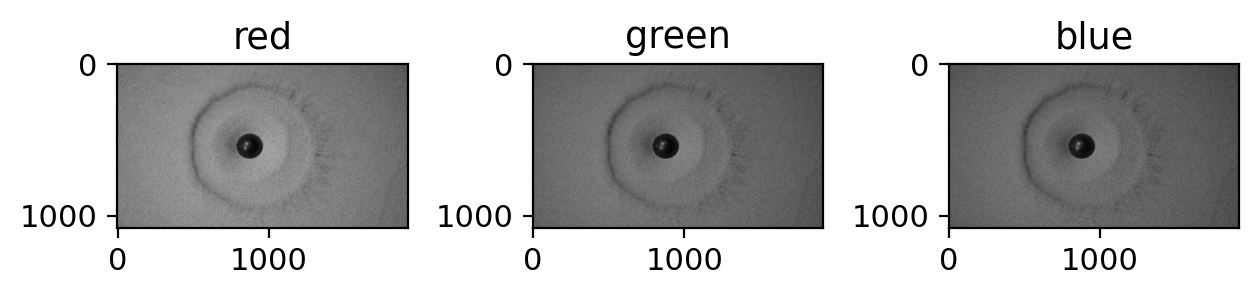

In [12]:
## Display the 3 color channels 
ii = 100

fig,ax = plt.subplots(1,3,dpi=200)
fig.tight_layout(h_pad=1)
ax[0].imshow(rframes[ii],'gray')
ax[0].set_title('red')
ax[1].imshow(gframes[ii],'gray')
ax[1].set_title('green')
ax[2].imshow(bframes[ii],'gray')
ax[2].set_title('blue')

### Median image subtraction
<a id='med_img_sub'></a>

In [13]:
idxx = 0 
diff = 5 # distance between images used for median 
end_med = 20 # last frame to be used as median 

In [14]:
# Make a median image 
bmedianim = np.median([frames[ii][:,:,2] for ii in range(idxx, end_med, diff)], axis=0)
rmedianim = np.median([frames[ii][:,:,0] for ii in range(idxx, end_med, diff)], axis=0)
gmedianim = np.median([frames[ii][:,:,1] for ii in range(idxx, end_med, diff)], axis=0)

# Substract median image from all frames
bproc = track_tools.subtract_median(bframes, bmedianim)
rproc = track_tools.subtract_median(rframes, rmedianim)
gproc = track_tools.subtract_median(gframes, gmedianim)

Text(0.5, 1.0, 'ag med sub')

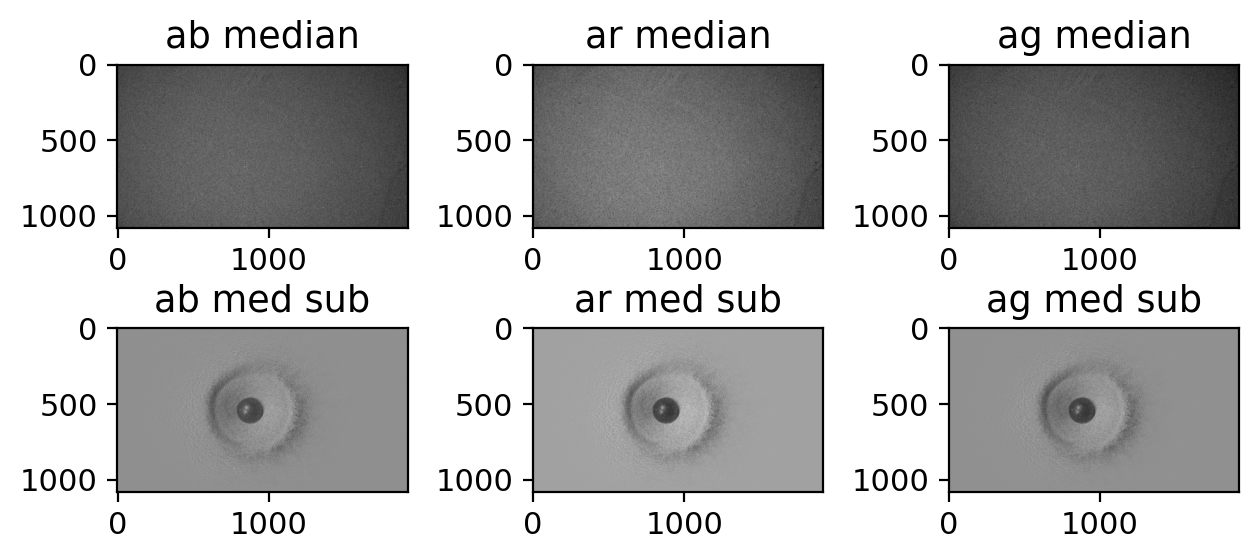

In [15]:
## Plot 3 color channels median subtract results
idx = 50

fig, ax = plt.subplots(2,3,dpi=200) 
fig.tight_layout(h_pad=-12) #
plt.setp(ax, yticks=[0,500,1000]) # sets tick marks for all subplots 

ax[0,0].imshow(bmedianim,'gray')
ax[0,0].set_title('ab median') 
ax[1,0].imshow(bproc[idx],'gray')
ax[1,0].set_title('ab med sub') 
ax[0,1].imshow(rmedianim,'gray')
ax[0,1].set_title('ar median') 
ax[1,1].imshow(rproc[idx],'gray')
ax[1,1].set_title('ar med sub') 
ax[0,2].imshow(gmedianim,'gray')
ax[0,2].set_title('ag median') 
ax[1,2].imshow(gproc[idx],'gray')
ax[1,2].set_title('ag med sub') 

# PIV analysis with OpenPIV (two frames)

In [16]:
## PIV parameters
winsize = 22 # pixels, interrogation window size in frame A
searchsize = 28  # pixels, search area size in frame B
overlap = 11 # pixels, 50% overlap
dt = 1/framerate # sec, time interval between the two frames

mm = 35 # index of some frame to test PIV parameters 

chosen_frames = bframes 

## Do PIV analysis 
u0, v0, sig2noise = pyprocess.extended_search_area_piv(
    chosen_frames[mm].astype(np.int32),
    chosen_frames[mm+1].astype(np.int32),
    window_size=winsize,
    overlap=overlap,
    dt=dt,
    search_area_size=searchsize,
    sig2noise_method='peak2peak',
) 

In [17]:
## Get coordinates of velocity vector positions
xx0, yy0 = pyprocess.get_coordinates(
    image_size=chosen_frames[mm].shape,
    search_area_size=searchsize,
    overlap=overlap,
) 

In [18]:
## Convert velocity vector arrow positions to centimeters
xx_cm = (xx0-xc)/pxscale
yy_cm = (yy0-yc)/pxscale

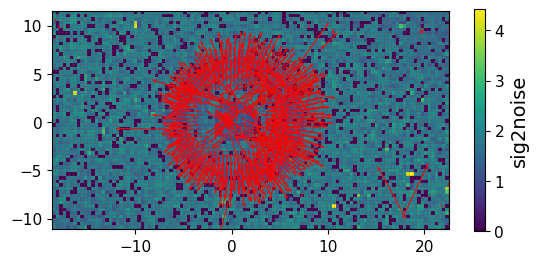

In [19]:
## Display velocity vectors w/ signal-to-noise ratios
fig,ax = plt.subplots(1,1,dpi=100)
cc = ax.imshow(sig2noise, extent=[xx_cm.min(), xx_cm.max(), yy_cm.min(), yy_cm.max()], vmin=sig2noise.min(), vmax=sig2noise.max())
ax.quiver(xx_cm, yy_cm, u0, v0, color='r')
cbar = plt.colorbar(cc, shrink=0.6)
cbar.set_label('sig2noise',fontsize=14) 

1.4519203559361382


<Axes: ylabel='counts'>

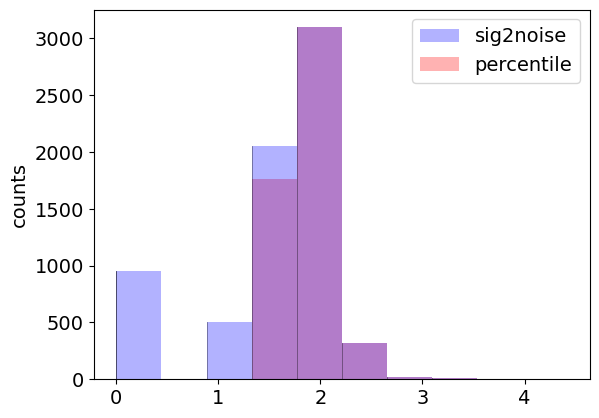

In [20]:
## Choose percent quartile to filter signal-to-noise ratios 
sig2noise_per_val = np.percentile(sig2noise, 25) # percentile filtering 
print(sig2noise_per_val)

sig2noise_bool = sig2noise>sig2noise_per_val
sig2noise_percent = sig2noise[sig2noise_bool]
# sig2noise_mask = np.ma.array(sig2noise, mask=sig2noise_bool)

piv_tools.plot_multi_hist_ebins(sig2noise.flatten(), sig2noise_percent.flatten(), ['sig2noise','percentile'], ['b','r'], [1,0], [0.3, 0.3],10)

In [21]:
## Identify vectors below some signal-to-noise ratio 
invalid_mask = validation.sig2noise_val(u0,v0,
    sig2noise,
    threshold = sig2noise_per_val, # 2.05
)

In [22]:
## Replace velocity vector components that do not meet masking threshold 
u1, v1 = filters.replace_outliers(
    u0, v0,
    invalid_mask,
    method='localmean',
    max_iter=3,
    kernel_size=3,
)

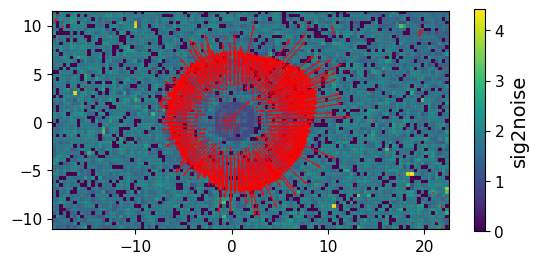

In [23]:
## Plot velocities filtered by signal-to-noise ratio threshold 
fig,ax = plt.subplots(1,1,dpi=100)
cc = ax.imshow(sig2noise, extent=[xx_cm.min(), xx_cm.max(), yy_cm.min(), yy_cm.max()], vmin=sig2noise.min(), vmax=sig2noise.max())
ax.quiver(xx_cm, yy_cm, u1, v1, color='r')

cbar = plt.colorbar(cc, shrink=0.6)
cbar.set_label('sig2noise',fontsize=14)

In [24]:
## Convert positions and velocities to physical units
# convert x,y to cm
# convert u,v to cm/sec
xx1, yy1, u2, v2 = scaling.uniform(
    xx0, yy0, u1, v1,
    scaling_factor = pxscale
)

## Shift origin of coordinate system to be bottom left corner
# 0,0 shall be bottom left, positive rotation rate is counterclockwise
xx2, yy2, u3, v3 = tools.transform_coordinates(xx1, yy1, u2, v2)

## Shift origin to center of impact site
xx2 = xx2 - xc/pxscale
yy2 = yy2 - yc/pxscale

Text(0.5, 0, 'y [cm]')

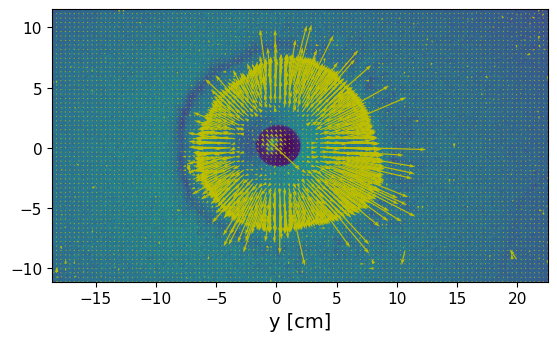

In [25]:
## Converted vel
fig,ax = plt.subplots(1,1,dpi=100)
ax.imshow(chosen_frames[100], extent=[xx2.min(), xx2.max(), yy2.min(), yy2.max()])

ax.quiver(xx2, yy2, u3, v3, color='y')#, scale=1000, width=0.0035) 

ax.set_xlabel('x [cm]') 
ax.set_xlabel('y [cm]') 

In [26]:
## Calculate velocity vectors 
vejecta_mag = np.sqrt(u3**2 + v3**2)

In [27]:
## Filter velocities by magnitudes 
vmag_per_val = np.percentile(vejecta_mag, 90) # 
print(vmag_per_val)

filt_cond = vejecta_mag > vmag_per_val
ind = np.where(filt_cond) # indices of surviving velocities 
# print('ind_shape: ', np.shape(ind))

vejecta_mag2 = np.zeros_like(vejecta_mag) 
vejecta_mag2[ind] = vejecta_mag[ind]

xx3 = np.zeros_like(xx2)
xx3[ind] = xx2[ind]

yy3 = np.zeros_like(yy2)
yy3[ind] = yy2[ind]

uu3 = np.zeros_like(u3)
uu3[ind] = u3[ind]

vv3 = np.zeros_like(v3)
vv3[ind] = v3[ind]


19.953829292796595


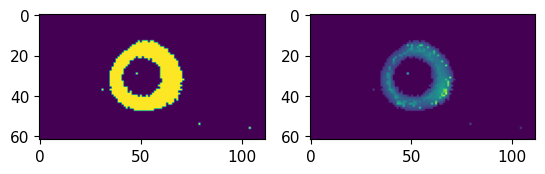

In [28]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(filt_cond) # surviving velocities 
ax[1].imshow(vejecta_mag2) 

Text(0.5, 0, '|v| [cm/s]')

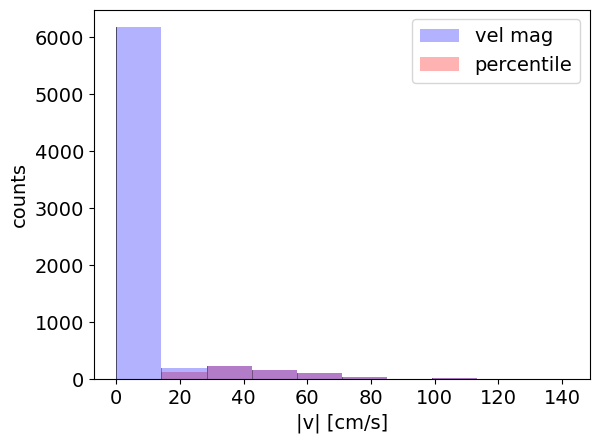

In [29]:
## Histograms of velocity magnitudes 
piv_tools.plot_multi_hist_ebins(vejecta_mag.flatten(), vejecta_mag2[vejecta_mag2>0].flatten(), ['vel mag','percentile'], ['b','r'], [1,0], [0.3, 0.3], 10)
plt.xlabel('|v| [cm/s]') 

Text(0.5, 1.0, 'Ejecta velocity field')

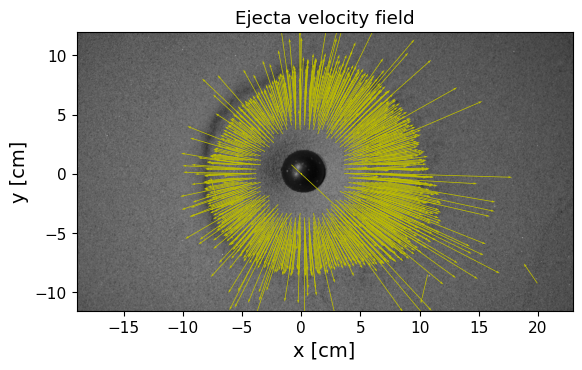

In [30]:
## Plot final velocities overlaying original frame 
fig,ax = plt.subplots(1,1,dpi=100) 
ax.imshow(chosen_frames[101], 'gray', extent=img_extent) 
ax.quiver(xx3, yy3, uu3, vv3, color='y', width=0.0015, scale=500)  

ax.set_xlabel('x [cm]') 
ax.set_ylabel('y [cm]') 
ax.set_title('Ejecta velocity field') 

In [31]:
# ## Plot final velocities w/ streamlines 
# fig,ax = plt.subplots(1,1,dpi=100) 
# ax.imshow(frames[301], extent=img_extent)
# ax.quiver(xx3, yy3, uu3, vv3, color='y')#, scale=600, width=0.0025) 

# mesh_x_length = np.shape(uu3)[1]
# mesh_y_length = np.shape(uu3)[0]
# XX, YY = np.meshgrid(np.linspace(-xc/pxscale,(nx-xc)/pxscale, mesh_x_length), np.linspace(-yc/pxscale, (ny-yc)/pxscale, mesh_y_length))
# aa = ax.streamplot(XX, YY, uu3, -vv3, color='m', cmap='viridis', density=[.5, .5], linewidth=1.)

# ax.set_xlabel('x [cm]')
# ax.set_ylabel('y [cm]')
# ax.set_title('Streamlines')  

In [32]:
# ## If one wants to do something with the streamlines, this gets the coordinates of the line segments of the streamlines 
# segments = aa.lines.get_segments() 
# len(segments) 
# segments[0] 

# PIV analysis (all frames)

In [33]:
## PIV parameters
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 38  # pixels, search area size in frame B
overlap = 17 # pixels, 50% overlap
dt = 1/framerate # sec, time interval between the two frames
sig2noise_percentile = 25
vmag_percentile = 90

piv_params_dict = {'winsize':winsize, 'searchsize':searchsize, 'overlap':overlap, 'dt':dt, \
                   'sig2noise_percentile':sig2noise_percentile, 'vmag_percentile':vmag_percentile, 'pxscale':pxscale}

In [34]:
## Do PIV on entire video 
x_pos, y_pos, u_vel, v_vel, vmags, vmag_thresh_low, vmag_thresh_upp, sig2noise_thresh = piv_tools.piv_analysis(chosen_frames, t0_frame, [xc,yc], piv_params_dict) 


  0%|          | 0/381 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Ejecta velocity field')

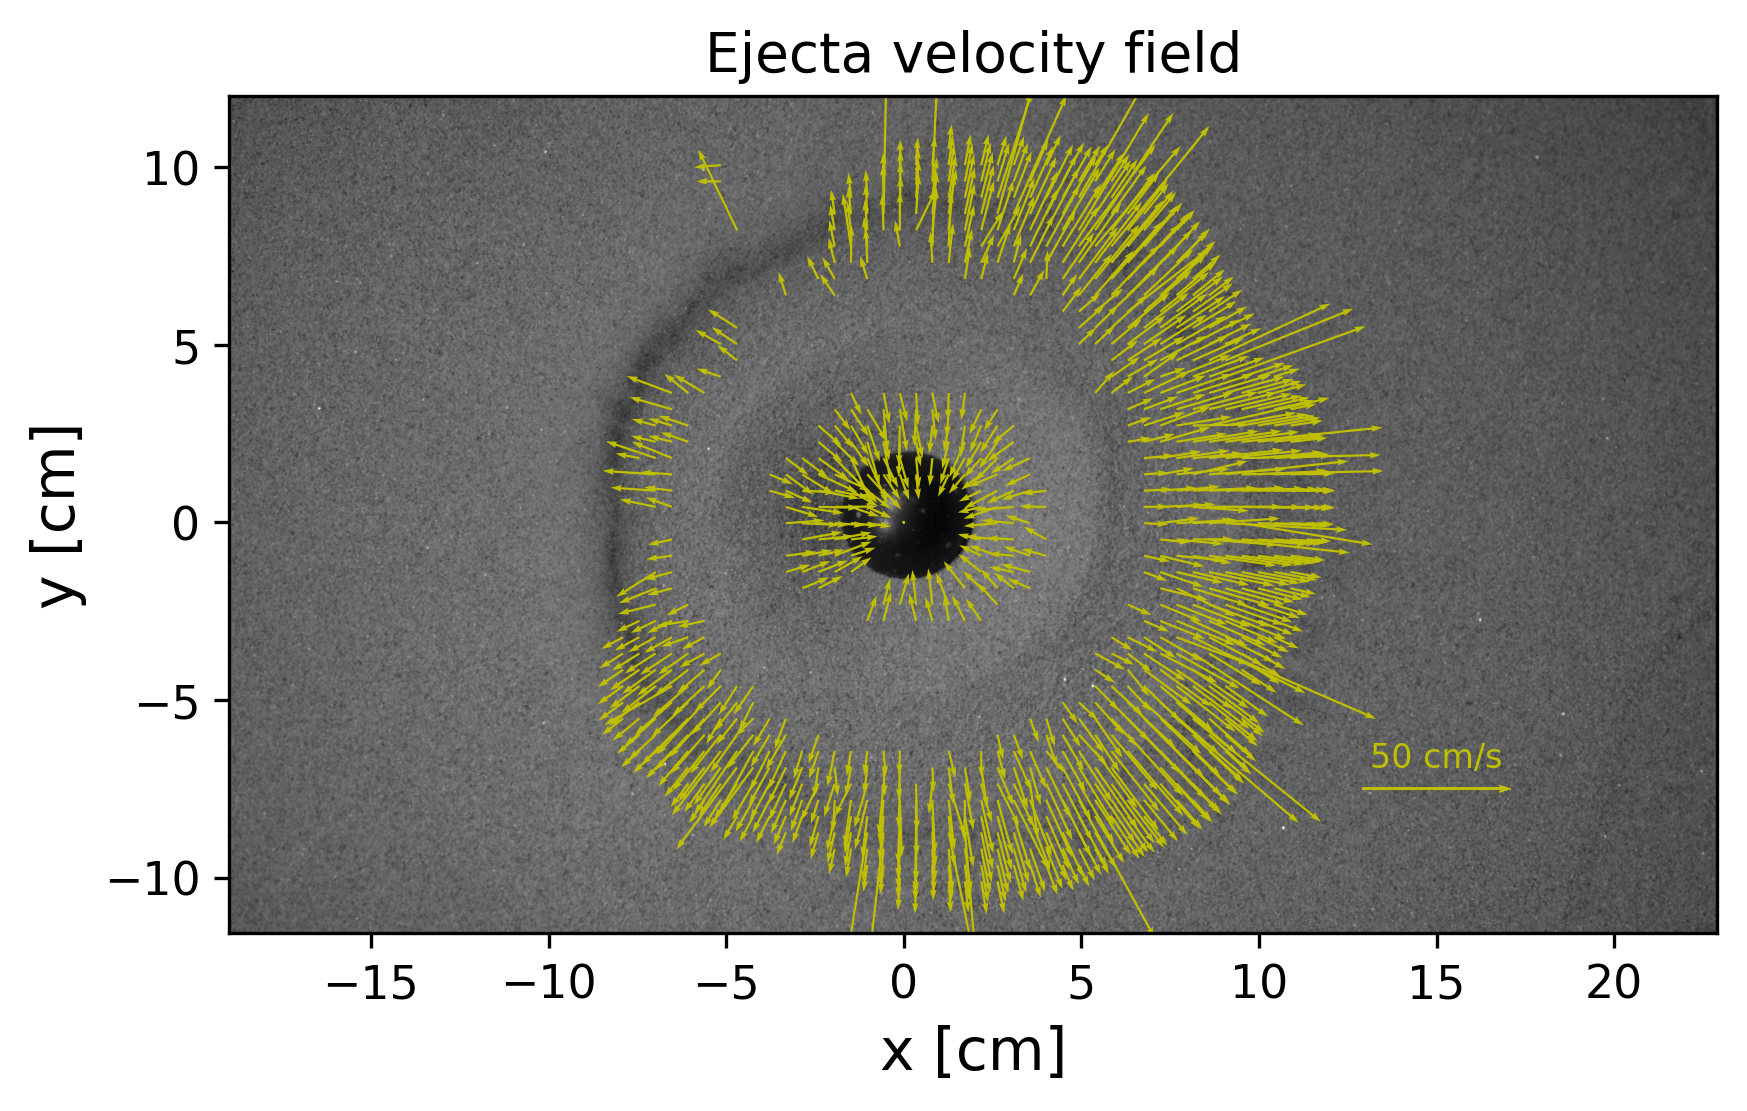

In [35]:
## Plot final velocities overlaying original frame 
qq = 101

fig,ax = plt.subplots(1,1,dpi=300) 
ax.imshow(chosen_frames[qq], 'gray', extent=img_extent) 

Q = ax.quiver(x_pos[qq], y_pos[qq], u_vel[qq], v_vel[qq], color='y', angles='xy', width=0.0015, scale=500) #
qk = ax.quiverkey(Q, 15, -7.5, 50, '50 cm/s', labelcolor='y', color='y', coordinates='data', labelpos='N', labelsep=0.05, fontproperties={'size':8}) #

ax.set_xlabel('x [cm]') 
ax.set_ylabel('y [cm]') 
ax.set_title('Ejecta velocity field') 

## Make grid on figures (this was to check the accuracy of arrow key length)
# xticks_grid = np.arange(-20, 21, 1)
# yticks_grid = np.arange(-20, 11, 1)
# ax.set_xticks(xticks_grid) 
# ax.set_yticks(yticks_grid) 
# plt.grid()


In [36]:
## Save PIV results 
piv_tools.save_piv_data(x_pos, y_pos, u_vel, v_vel, output_dir) 

In [37]:
## Make velocity field figures/frames 
piv_tools.make_vfield_frames(frames[t0_frame:stop_frame], x_pos, y_pos, u_vel, v_vel, framerate, t0_frame+1, [xc,yc], img_extent, output_dir+'piv_vfield_data/') 


  0%|          | 0/381 [00:00<?, ?it/s]

In [38]:
## Save histograms of velocity magnitudes 
piv_tools.make_vmag_hists(vmags, t0_frame, framerate, 'Ejecta velocity magnitude', output_dir+'piv_vmag_hists/') 

Text(0, 0.5, 's2n thresh')

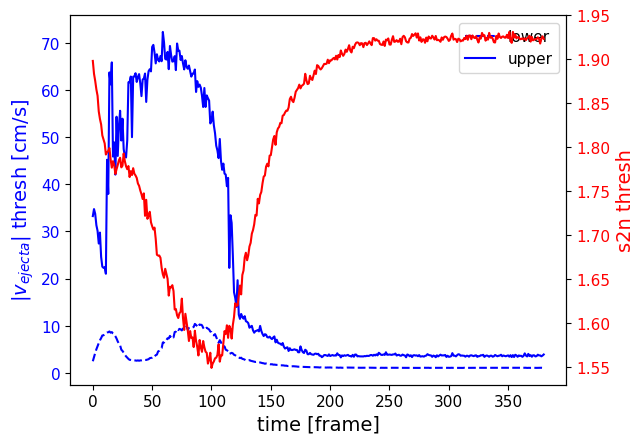

In [39]:
## Comparison of |v| and sig2noise threshold over time 
fig,ax1 = plt.subplots(1,1)
color1 = 'blue'
color2 = 'red'

ax1.set_xlabel('time [frame]') # does this start at t0_frame? not nescessarily... 
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylabel(r'|$v_{ejecta}$| thresh [cm/s]', color=color1) 

ax1.plot(vmag_thresh_low, color=color1, ls='--', label='lower')
ax1.plot(vmag_thresh_upp, color=color1, label='upper')

plt.legend()

ax2 = ax1.twinx()
ax2.plot(sig2noise_thresh, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylabel('s2n thresh', color=color2)

vel component cutoff: 6.96 [cm/s] (i.e. 10.0 percent)
num vectors after filtering: 88379


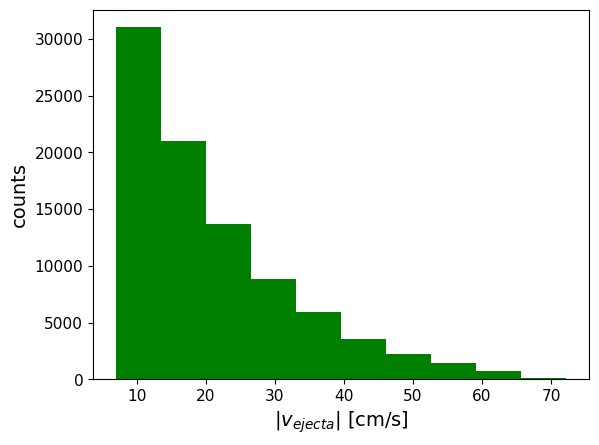

In [40]:
## Histogram of all velocities thru duration of video
percent_cutoff = 0.1
if np.max(u_vel) >= np.max(v_vel):
    vel_comp_cutoff = percent_cutoff*np.max(u_vel)
else:
    vel_comp_cutoff = percent_cutoff*np.max(v_vel)

print('vel component cutoff: %.2f [cm/s] (i.e. %.1f percent)' %(vel_comp_cutoff, percent_cutoff*100) ) 


u_vel_flat = np.array(u_vel).flatten()
v_vel_flat = np.array(v_vel).flatten()
# u_vel_flat_filt = u_vel_flat[u_vel_flat>0]
# v_vel_flat_filt = v_vel_flat[v_vel_flat>0]

# vel_comp_cutoff = 5.5 
u_vel_bool = np.abs(u_vel_flat) > vel_comp_cutoff
v_vel_bool = np.abs(v_vel_flat) > vel_comp_cutoff
idxs = np.where([a or b for a,b in zip(u_vel_bool, v_vel_bool)])[0]
u_vel_flat_filt = u_vel_flat[idxs]
v_vel_flat_filt = v_vel_flat[idxs]

print('num vectors after filtering: %i' %len(u_vel_flat_filt))

fig, ax = plt.subplots(1,1)
ax.hist(np.sqrt(u_vel_flat_filt**2 + v_vel_flat_filt**2), color='g')
ax.set_ylabel('counts')
ax.set_xlabel('|$v_{ejecta}$| [cm/s]')

plt.savefig(output_dir+'mag_v_hist.png',dpi=200, bbox_inches='tight') 
plt.savefig(output_dir+'mag_v_hist.svg') 

# Postcards

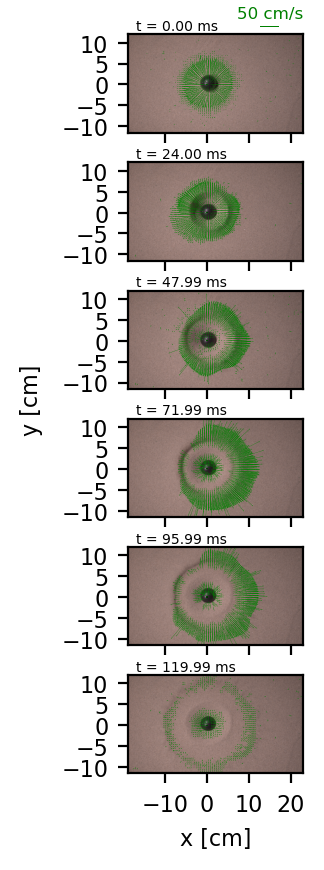

In [41]:
## Plot postcards of piv results 
N = 6
nn = 6
arrow_size = 50
arrow_color = 'g'
plt.rcParams.update({'xtick.labelsize': 8})    # fontsize of the xtick labels
plt.rcParams.update({'ytick.labelsize': 8})    # fontsize of the ytick labels

## Plot final velocities overlaying original frame 
fig, ax = plt.subplots(N, 1, dpi=200, sharex = True) 
plt.subplots_adjust(hspace=0.3)

for ii, kk in enumerate(np.linspace(0, 120, nn)): # change middle number to, effectively, determine how much of the movie will be shown in the postcards.
    kk=int(kk) 
    
    if kk>len(chosen_frames):
        break
    
    ax[ii].imshow(frames[t0_frame:stop_frame][kk], extent=img_extent, vmin=0, vmax=255, cmap='gray')
    Q = ax[ii].quiver(x_pos[kk], y_pos[kk], u_vel[kk], v_vel[kk], color=arrow_color, angles='xy', width=0.0015, scale=500) #

    ax[ii].text(-17.0, 13., 't = %.2f ms' %((kk)/framerate*1000), fontsize=5)
    ax[ii].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax[ii].yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

qk = plt.quiverkey(Q, 15, 167., arrow_size, '%s cm/s' %arrow_size, labelcolor=arrow_color, color=arrow_color, coordinates='data', labelpos='N', labelsep=0.03, fontproperties={'size':6}) #

## Plot axes labels 
plt.xlabel('x [cm]', fontsize=8) 
fig.text(0.36, 0.5, 'y [cm]', va='center', rotation='vertical', fontsize=8)


plt.savefig(output_dir+'piv_postcards.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'piv_postcards.svg') #, dpi=500, bbox_inches='tight')

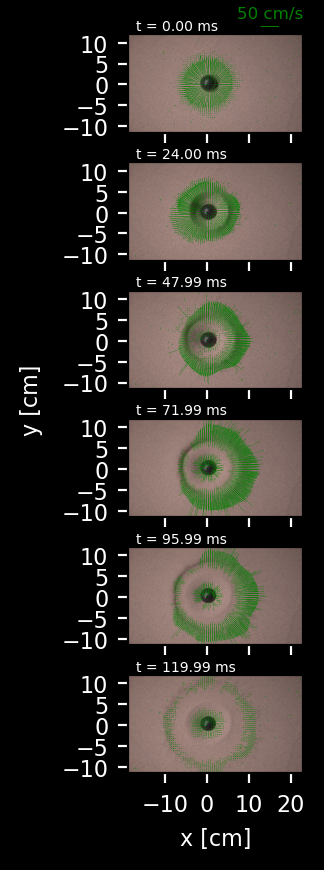

In [42]:
## Plot postcards of piv results 
N = 6
nn = 6
arrow_size = 50
arrow_color = 'g'
plt.rcParams.update({'xtick.labelsize': 8})    # fontsize of the xtick labels
plt.rcParams.update({'ytick.labelsize': 8})    # fontsize of the ytick labels

## Plot final velocities overlaying original frame 
fig, ax = plt.subplots(N, 1, dpi=200, sharex = True, facecolor='k') 
plt.subplots_adjust(hspace=0.3)

for ii, kk in enumerate(np.linspace(0, 120, nn)): # change middle number to, effectively, determine how much of the movie will be shown in the postcards.
    kk=int(kk) 
    
    if kk>len(chosen_frames):
        break
    
    ax[ii].imshow(frames[t0_frame:stop_frame][kk], extent=img_extent, vmin=0, vmax=255, cmap='gray')
    Q = ax[ii].quiver(x_pos[kk], y_pos[kk], u_vel[kk], v_vel[kk], color=arrow_color, angles='xy', width=0.0015, scale=500) #

    ax[ii].text(-17.0, 13., 't = %.2f ms' %((kk)/framerate*1000), fontsize=5, color='w')
    ax[ii].xaxis.set_major_locator(mpl.ticker.MultipleLocator(10))
    ax[ii].yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
    # ax[ii].xaxis.label.set_color('w')

    # ax[ii].spines['left'].set_color('w')
    ax[ii].tick_params(colors='w', which='both')
    # ax[ii].tick_params(axis='y', color='w')

qk = plt.quiverkey(Q, 15, 167., arrow_size, '%s cm/s' %arrow_size, labelcolor=arrow_color, color=arrow_color, coordinates='data', labelpos='N', labelsep=0.03, fontproperties={'size':6}) #

## Plot axes labels 
plt.xlabel('x [cm]', fontsize=8, color='w') 
fig.text(0.36, 0.5, 'y [cm]', va='center', rotation='vertical', fontsize=8, color='w')


plt.savefig(output_dir+'piv_postcards_dark.png', dpi=500, bbox_inches='tight')
plt.savefig(output_dir+'piv_postcards_dark.svg') #, dpi=500, bbox_inches='tight')

Directory 'piv_output/vid01_xy_single/piv_ang_polar_hist_postcard/' already exists.
vel component cutoff: 6.96 [cm/s] (i.e. 10.0 percent)
max bin count 69


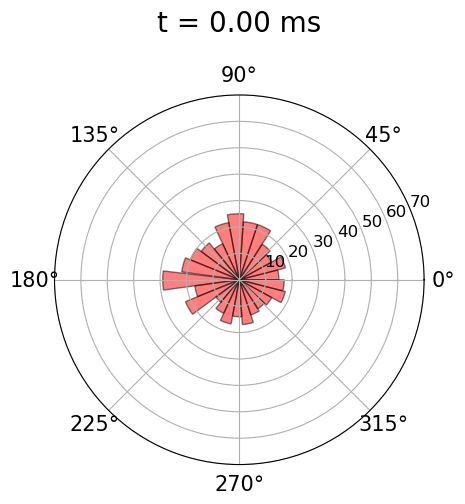

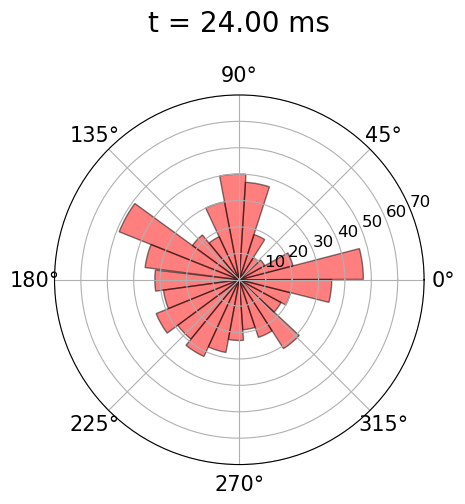

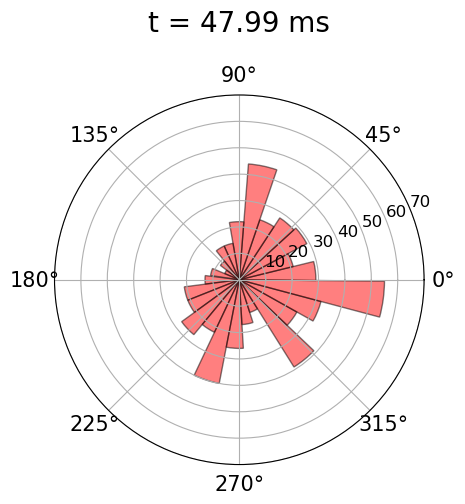

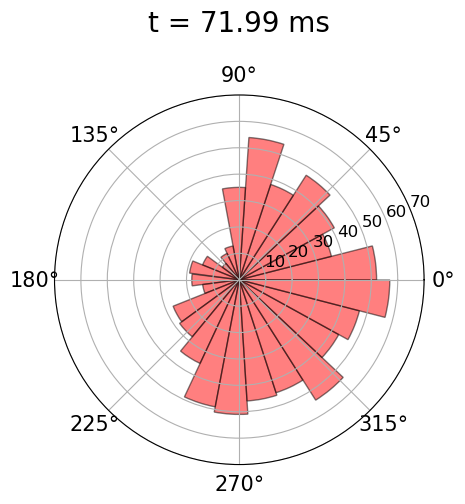

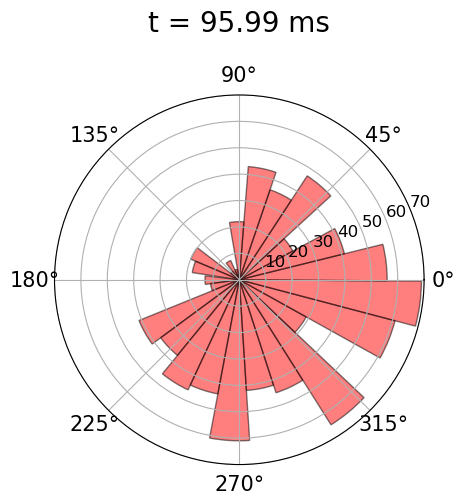

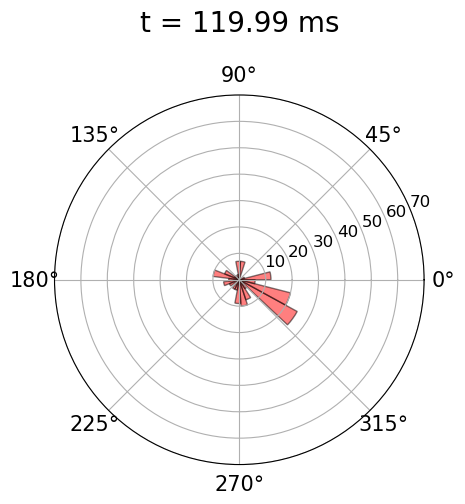

In [43]:
## Plot postcards of piv results 
nn = 6
nbins = 25
fs = 15

plt.rcParams.update({'xtick.labelsize': 8})    # fontsize of the xtick labels
plt.rcParams.update({'ytick.labelsize': 8})    # fontsize of the ytick labels

## Create the save directory
save_dir = output_dir+'piv_ang_polar_hist_postcard/'
try:
    os.mkdir(save_dir)
    print(f"Directory '{save_dir}' created successfully.")
except FileExistsError:
    print(f"Directory '{save_dir}' already exists.")

max_hist_count = []
histvals_postcards = []
histedges_postcards = [] 
kk_vals = [] 

## Get velocity component cutoff value
percent_cutoff = 0.1
if np.max(u_vel) >= np.max(v_vel):
    vel_comp_cutoff = percent_cutoff*np.max(u_vel)
else:
    vel_comp_cutoff = percent_cutoff*np.max(v_vel)

print('vel component cutoff: %.2f [cm/s] (i.e. %.1f percent)' %(vel_comp_cutoff, percent_cutoff*100) ) 


for ii, kk in enumerate(np.linspace(0, 120, nn)):
    
    kk=int(kk) 
    if kk>len(chosen_frames):
        break

    angles_deg = piv_tools.get_angles_from_vel_components(u_vel[kk], v_vel[kk], vel_comp_cutoff)

    histvals, histedges = np.histogram(angles_deg, bins=nbins)
    max_hist_count.append(np.max(histvals))
    histvals_postcards.append(histvals)
    histedges_postcards.append(histedges)
    kk_vals.append(kk)

max_counts = np.max(max_hist_count)
print('max bin count', np.max(max_hist_count))

## Plot polar histogram postcards 
for jj, (histvals, edges, kk) in enumerate(zip(histvals_postcards, histedges_postcards, kk_vals)):
    
    fig, ax = plt.subplots(1, 1, dpi=100, sharex=True, subplot_kw=dict(projection="polar")) 
    ax_offset = 5
    wedge_width = (edges[1]-edges[0])*np.pi/180 # angular bin width  
    bars = ax.bar(edges[:-1]*np.pi/180, histvals, width=wedge_width, bottom=0.0)#, color='r', alpha=0.5)
    
    # Customize parameters of the bars
    for r, bar in zip(histvals, bars):
        bar.set_edgecolor('k') # edge color
        bar.set_facecolor('red') # fill color
        bar.set_alpha(0.5) # fill opacity
    
    ax.tick_params(axis='y', labelrotation=0, labelsize=12)
    ax.tick_params(axis='x', labelrotation=0, labelsize=fs)
    
    multiple = 10
    ax.set_ylim([0,max_counts + multiple-max_counts%multiple])

    ax.set_title('t = %.2f ms' %((kk)/framerate*1000), y=1.15, fontsize=20)

    fig.savefig(save_dir+'piv_postcards_%i.png' %(kk+t0_frame), dpi=500, bbox_inches='tight')
    plt.savefig(save_dir+'piv_postcards_%i.svg' %(kk+t0_frame)) #, dpi=500, bbox_inches='tight')